create a quiver plot of gradients which continuously updates itself. Usefull in alignin the heater.

In [1]:
import os
import sys

# import useful things
from IPython import display
import matplotlib.pyplot as plt
import sys
import numpy as np

#Import ximea (camera software)
sys.path.append('C:/XIMEA/API/Python/v3')
import ximea
print(ximea.__version__)
import ximea.xiapi as xiapi

from skimage import filters
from skimage.measure import regionprops

# Import HS classes assuming they reside one directory above
hspath = os.path.abspath('..')
if hspath not in sys.path:
    sys.path.append(hspath)

from HWS.HS_Image import *
from HWS.HS_Centroids import *
from HWS.HS_Gradients import *
from HWS.HS_WFP import *
import HWS.HSM_WFN as HSM_WFN


4.28.00


In [3]:
# size of image taken by HWS (pixels)
img_size = 2048
# distance from CCD array to Heartmann plate
lever_arm = 8.73e-3 # (m)
# magnification due to imaging telescope
magnification = 1/0.509
# pixel size in CCD array
pixel_size = 5.5e-6
# wavelength of SLD light (m)
wavelength = 830e-9
# distance between holes on the Heartmann plate
hole_spacing = 4e-4 # (m)
# origin
origin = 2047/2
# centre of image
center = float(img_size / 2)

# camera exposure for HWS (us)
exposure = 1505

# camera settings
cam = xiapi.Camera()
cam.open_device()

cam.set_exposure(exposure)
cam.set_imgdataformat('XI_MONO16')

In [4]:
def get_the_frame(cam):
    '''take image with camera as numpy array'''
    while True:
            img = xiapi.Image()
            cam.get_image(img)
            image = img.get_image_data_numpy()

            return(image)

In [5]:
def take_and_average_frames(cam, N):
    """_summary_

    Args:
        cam (_type_): _xiapi.camera_
        N (_int_): _number_of_frames_

    Returns:
        _np.array_: _average_image_
    """
    cam.start_acquisition()
    img = xiapi.Image()
    temp = np.zeros((img_size, img_size))
    for i in range(N):
        cam.get_image(img)
        temp += img.get_image_data_numpy()
    cam.stop_acquisition()

    return (temp / N)




def remove_nasty_gradients(gradients, factor):
    '''find and remove gradinets which are outliers (exessively large)
    
    Args:
        gradients (_np.array_): gradients, as found from centroids

    Returns: _np.array_: gradients, with outliers removed
    '''

    bad_no = []
    average_gradient = np.mean(np.sqrt((gradients[:,0])**2) + (gradients[:,1])**2)
    print('ave', average_gradient)
    sd_gradient = np.std(np.sqrt((gradients[:,0])**2) + (gradients[:,1])**2)
    print('sd', sd_gradient)
    limit = average_gradient + (sd_gradient * factor)
    
    for i,_ in enumerate(gradients[:, 0]):

        if np.sqrt(((gradients[i,0])**2) + (gradients[i,1])**2) > limit:
            bad_no.append(i)    
            gradients[i] = average_gradient
    # return np.delete(gradients, bad_no, axis = 0)
    return gradients

In [ ]:
# take a test image
cam.stop_acquisition()
cam.start_acquisition()
img = xiapi.Image()
cam.get_image(img)
test_image = img.get_image_data_numpy()
max = test_image.max()
print(max)
y_bad, x_bad = np.where(test_image == max)
print(x_bad, y_bad)
print(test_image[y_bad, x_bad])
test_image[y_bad, x_bad] = 0


cam.stop_acquisition()

1023
[886 887 886 ... 805 806 845] [ 522  522  523 ... 1896 1896 1964]
[1023 1023 1023 ... 1023 1023 1023]


KeyboardInterrupt: 

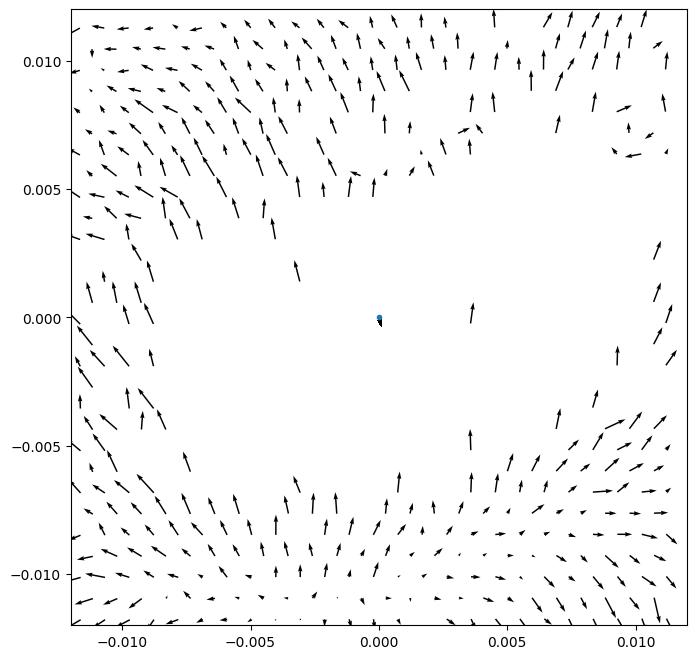

In [7]:
# format plot
fig = plt.figure(figsize = (8, 8))

cam.stop_acquisition()

background = 2

hsi_ref = HS_Image()
hsi_ref.background = background

hsi_ref.original_image = take_and_average_frames(cam, 100)
hsi_ref.original_image.shape = (img_size, img_size)


hsi_ref.process_image()

hsc_ref = HS_Centroids()
hsc_ref.hsimage = hsi_ref
hsc_ref.radius = 10
hsc_ref.find_centroids_from_image()
ref_cents = hsc_ref.centroids
plt.xlim(-12e-3, 12e-3)
plt.ylim(-12e-3, 12e-3)
plt.plot(0,0,'.')
plt.gca().set_aspect('equal')
ref_cents[:,0].min(),
input(prompt='ref taken')
p=None
while True: #run forever
    
    hsi_live = HS_Image()
    hsi_live.background = background

    hsi_live.original_image = take_and_average_frames(cam, 10)
    hsi_live.original_image.shape = (img_size, img_size)

    hsi_live.process_image()

    hsc_live = HS_Centroids()
    hsc_live.hsimage = hsi_live

    hsc_live.find_centroids_using_template(refcents= hsc_ref.centroids)

    live_cents = hsc_live.centroids

    hsg = HS_Gradients(hsc_ref, hsc_live)
    hsg.origin = array([(img_size - 1)/2, (img_size - 1)/2])
    hsg.construct_gradients()

    raw_gradients = hsg.gradients

    # nice gradients
    nice_grads = remove_nasty_gradients(raw_gradients, factor = 2)
    hsg_ng = HS_Gradients()
    # hsg.origin = array([origin, origin])
    # hsg.pixel_size = pixel_size
    # hsg.magnification = magnification
    hsg_ng.gradients = nice_grads
    hsg_ng.final_centroids = nice_grads[:,2:]


    prism_x = np.mean(hsg.gradients[:, 0])
    prism_y = np.mean(hsg.gradients[:, 1])

    hsg_noprism = hsg

    hsg_noprism.gradients[:, 0] = hsg.gradients[:, 0] - prism_x
    hsg_noprism.gradients[:, 1] = hsg.gradients[:, 1] - prism_y
    if p is not None:
    
        p.remove()
    p = plt.quiver(hsg_noprism.gradients[:,2],hsg_noprism.gradients[:,3],hsg_noprism.gradients[:,0],hsg_noprism.gradients[:,1])

    display.display(plt.gcf())  # select current figure
    display.clear_output(wait=True)  #clear plot 

    


https://matplotlib.org/stable/users/explain/animations/blitting.html

use this method to make plot update faster

In [41]:
print(frame[x_bad, y_bad])
print(x_bad, y_bad,x,y)

[15]
[493] [1745] [493] [1745]


In [4]:
cam.stop_acquisition()
cam.close_device()